In [1]:
import gc
import os
import numpy as np 
import pandas as pd 
import utils.paths as plh
import matplotlib.pyplot as plt
import utils.read_utils as hlpread
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from src.models.predict_model import employee_access_resource
from src.models.feature_eng.TE_KFold import KFoldTargetEncoder
from src.models.feature_eng.FreqEncoding import FrequencyEncoding
from src.models.feature_eng.Combine_feature import CombineFeatures
from src.models.feature_eng.KFoldFreqEncoding import KFoldFrequencyEncoding
from src.models.feature_eng.CountVectorizerEncoding import CountVectorizerEncoding
from src.models.feature_eng.TFIDFVectorizerEncoding import TFIDFVectorizerEncoding

In [2]:
PROJECT_ROOT = plh.get_project_root()

In [2]:
train_data = os.path.join(PROJECT_ROOT, 
                          hlpread.read_yaml_key('data_source.data_folders'),
                          hlpread.read_yaml_key('data_source.prepared.folder'),
                          hlpread.read_yaml_key('data_source.prepared.clean_train'),
                        )
train = hlpread.read_from_parquet(train_data)

print(train.shape)

print(train.columns)
#col_use = [x for x in train.columns if not x in ['ROLE_TITLE', 'MGR_ID']]
#train = train[col_use]
#targetcol = 'ACTION'

#te_col = list(train.columns)
#te_col.remove(targetcol)

(30391, 10)
Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE'],
      dtype='object')


# Eval performance of experiment models #

## Experiment 1: Using Decision Tree ##

### Trial 1 ###
 
**Paramaters**
- random_state: 988
- max_depth: 40
- splitter: best
- min_samples_leaf: 0.001
- max_features: 0.8  

**Feature Eng Pipeline**
- frequency_encoding: true

    *Params:*
    
        - min_group_size: 2
        - n_fold: 5
        - random_seed: 2023
        - targetcol: ACTION
        - log_transform: true
        - columns: #List of columns for feature encode
            - ROLE_DEPTNAME
            - ROLE_ROLLUP_1_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_CODE
            - ROLE_DEPTNAME_ROLE_FAMILY_DESC
            - ROLE_DEPTNAME_ROLE_FAMILY
            - ROLE_DEPTNAME_ROLE_CODE
    
- resource_catagory_encode: true

    *Params:*

        - column_to_consider:
            - ROLE_DEPTNAME_ROLE_FAMILY

In [4]:
model_obj = employee_access_resource(os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.model_path')),
                                     os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.feature_eng')))


<AxesSubplot:>

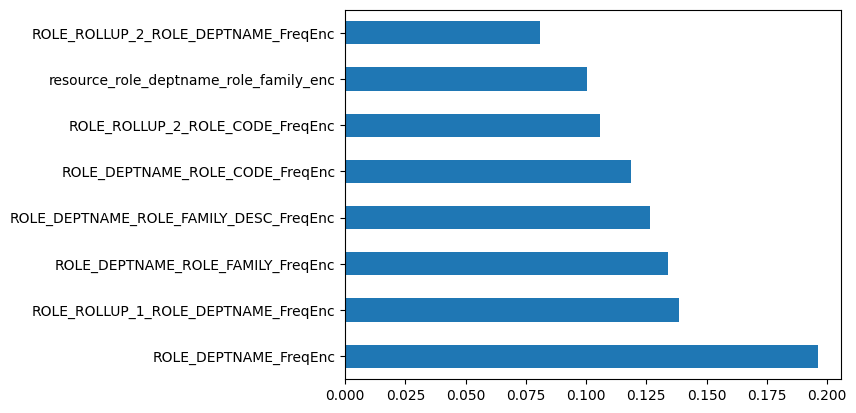

In [5]:
feat_importances = pd.Series(model_obj.model.feature_importances_, index = model_obj.model.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh')

**Observation:**
 - ROLE_DEPTNAME_FreqEnc has is the most importance feature.

In [19]:
#train.drop(['ROLE_TITLE', 'MGR_ID'], axis = 1, inplace = True)
Y_predictions_by_class = model_obj.predict(train).astype(float) #Return 2d numpy array which is the probaility for each class label
Y = train['ACTION'].astype(float)

In [7]:
Y_predictions_by_class

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.20930233, 0.79069767],
       ...,
       [0.04545455, 0.95454545],
       [0.06153846, 0.93846154],
       [0.03125   , 0.96875   ]])

In [10]:
auc_curve = roc_auc_score(Y, Y_predictions_by_class[:,1])
fpr, tpr, thresholds = roc_curve(Y, Y_predictions_by_class[:,1])

roc_auc_curve_df = pd.DataFrame()    
roc_auc_curve_df['false_positive_rates'] = fpr
roc_auc_curve_df['true_positive_rates'] = tpr
roc_auc_curve_df['thresholds'] = thresholds

roc_auc_curve_df.sort_values(by = 'true_positive_rates', ascending = False, inplace = True)

Text(0.5, 0, 'ROC-AUC: 0.901')

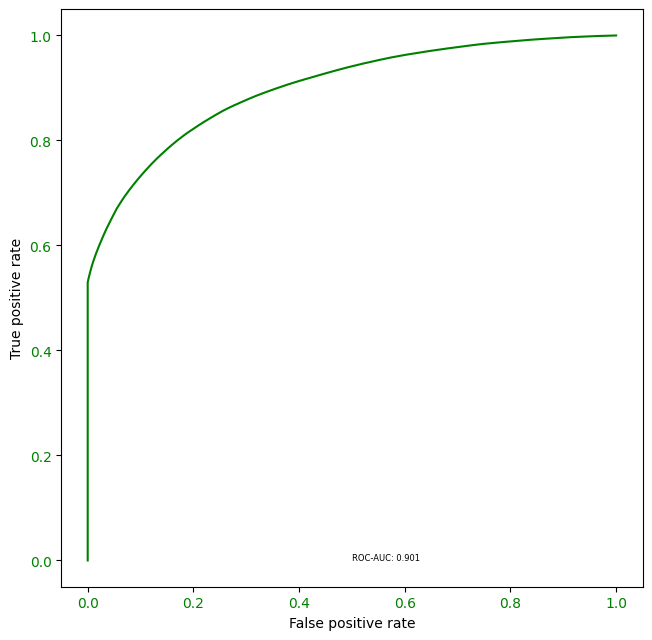

In [12]:
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(roc_auc_curve_df['false_positive_rates'], roc_auc_curve_df['true_positive_rates'],  color = 'green', label = 'ROC Curve') #, marker = 'o'

ax.tick_params(axis = 'both', labelcolor = 'green')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
label_str = str.format('ROC-AUC: {0}',  round(auc_curve, 3))
ax.text(0.5, 0, label_str, fontsize = 6)

In [ ]:
"""
pr, rc, thresholds = precision_recall_curve(Y,  Y_predictions_by_class[:,1])
pr_auc_score = average_precision_score(Y,  Y_predictions_by_class[:,1])

pr_rc_curve_df = pd.DataFrame()    
pr_rc_curve_df['precision'] = pr
pr_rc_curve_df['recall'] = rc
pr_rc_curve_df['thresholds'] = np.insert(thresholds, len(thresholds), np.nan)

fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(pr_rc_curve_df['recall'], pr_rc_curve_df['precision'], color = 'red', label = 'Precision - Recall Curve') #, marker = '-'

ax.tick_params(axis = 'both', labelcolor = 'red')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

label_str = str.format('PR-RC-AUC: {0}',  round(pr_auc_score, 3))
ax.text(0.5, 1, label_str, fontsize = 6)

plt.show()
"""

In [13]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold = %f, G-Mean = %.3f' % (thresholds[ix], gmeans[ix]))

#Y_pred = Y_predictions_by_class.argmax(-1)  
#1.0 if Y_predictions_by_class[:,1] > 0.9 else 0.0
threshold = thresholds[ix]
Y = np.array(Y).astype(int)
Y_pred = (Y_predictions_by_class[:,1] > threshold).astype(int)
Y_pred

Best Threshold=0.934426, G-Mean=0.816


array([1, 1, 0, ..., 1, 1, 1])

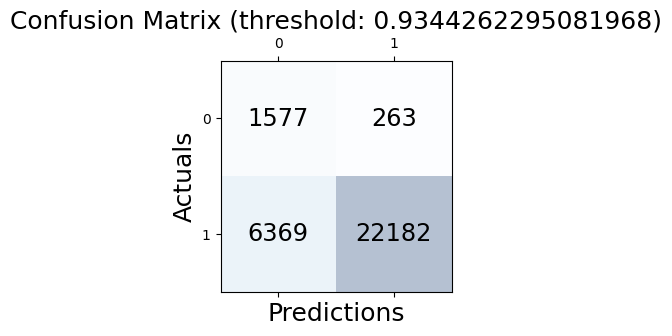

In [14]:
conf_matrix = confusion_matrix(Y, Y_pred)

#print(conf_matrix)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):

    for j in range(conf_matrix.shape[1]):

        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'xx-large')


plt.ylabel('Actuals', fontsize=18)
plt.xlabel('Predictions', fontsize=18)
plt.title(f'Confusion Matrix (threshold: {threshold})', fontsize = 18)
plt.show()

In [16]:
print(f'Balance accuracy score: {balanced_accuracy_score(Y, Y_pred)} when threshold {threshold}')

print(f"Classification report with threshold {threshold}")
print(classification_report(Y, Y_pred))

Balance accuracy score: 0.816995359562522 when threshold 0.9344262295081968
Classification report with threshold 0.9344262295081968
              precision    recall  f1-score   support

           0       0.20      0.86      0.32      1840
           1       0.99      0.78      0.87     28551

    accuracy                           0.78     30391
   macro avg       0.59      0.82      0.60     30391
weighted avg       0.94      0.78      0.84     30391



**Output:**

<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.71</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.90</td>
    <td>0.75</td>
</tr>
</table>

This can be our baseline model

### Trial 2 ###
 
**Paramaters**
- random_state: 988
- max_depth: 40
- splitter: best
- min_samples_leaf: 0.001
- max_features: 0.8  

**Feature Eng Pipeline**
- frequency_encoding: true

    *Params:*
    
        - min_group_size: 2
        - n_fold: 5
        - random_seed: 2023
        - targetcol: ACTION
        - log_transform: true
        - columns: #List of columns for feature encode
            - ROLE_DEPTNAME
            - ROLE_ROLLUP_1_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_CODE
            - ROLE_DEPTNAME_ROLE_FAMILY_DESC
            - ROLE_DEPTNAME_ROLE_FAMILY
            - ROLE_DEPTNAME_ROLE_CODE
    
- resource_catagory_encode: true

    *Params:*

        - column_to_consider:
            - ROLE_DEPTNAME_ROLE_FAMILY
            - ROLE_ROLLUP_1_ROLE_FAMILY

In [3]:
model_obj = employee_access_resource(os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.model_path')),
                                     os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.feature_eng')))


<AxesSubplot:>

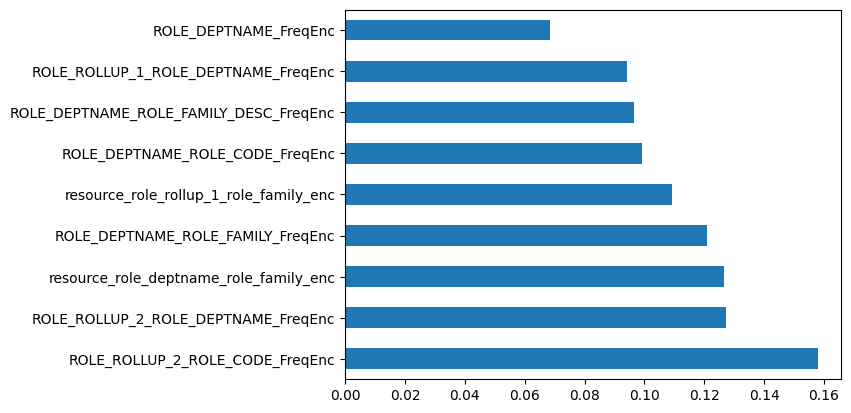

In [4]:
feat_importances = pd.Series(model_obj.model.feature_importances_, index = model_obj.model.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh')

In [5]:
Y_predictions_by_class = model_obj.predict(train).astype(float) #Return 2d numpy array which is the probaility for each class label
Y = train['ACTION'].astype(float)

Text(0.5, 0, 'ROC-AUC: 0.902')

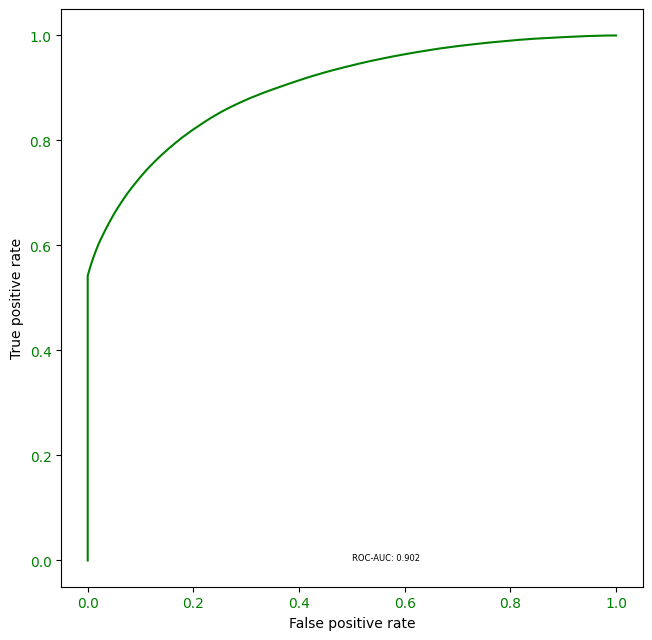

In [6]:
auc_curve = roc_auc_score(Y, Y_predictions_by_class[:,1])
fpr, tpr, thresholds = roc_curve(Y, Y_predictions_by_class[:,1])

roc_auc_curve_df = pd.DataFrame()    
roc_auc_curve_df['false_positive_rates'] = fpr
roc_auc_curve_df['true_positive_rates'] = tpr
roc_auc_curve_df['thresholds'] = thresholds

roc_auc_curve_df.sort_values(by = 'true_positive_rates', ascending = False, inplace = True)
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(roc_auc_curve_df['false_positive_rates'], roc_auc_curve_df['true_positive_rates'],  color = 'green', label = 'ROC Curve') #, marker = 'o'

ax.tick_params(axis = 'both', labelcolor = 'green')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
label_str = str.format('ROC-AUC: {0}',  round(auc_curve, 3))
ax.text(0.5, 0, label_str, fontsize = 6)

In [7]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold = %f, G-Mean = %.3f' % (thresholds[ix], gmeans[ix]))

#Y_pred = Y_predictions_by_class.argmax(-1)  
#1.0 if Y_predictions_by_class[:,1] > 0.9 else 0.0
threshold = thresholds[ix]
Y = np.array(Y).astype(int)
Y_pred = (Y_predictions_by_class[:,1] > threshold).astype(int)

Best Threshold = 0.934783, G-Mean = 0.815


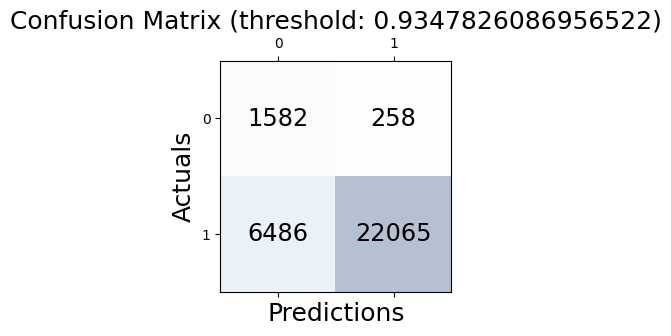

In [8]:
conf_matrix = confusion_matrix(Y, Y_pred)

#print(conf_matrix)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):

    for j in range(conf_matrix.shape[1]):

        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'xx-large')


plt.ylabel('Actuals', fontsize=18)
plt.xlabel('Predictions', fontsize=18)
plt.title(f'Confusion Matrix (threshold: {threshold})', fontsize = 18)
plt.show()

In [10]:
print(f'Balance accuracy score: {balanced_accuracy_score(Y, Y_pred)} when threshold {threshold}')

print(f"Classification report with threshold {threshold}")
print(classification_report(Y, Y_pred))

Balance accuracy score: 0.8163050902047138 when threshold 0.9347826086956522
Classification report with threshold 0.9347826086956522
              precision    recall  f1-score   support

           0       0.20      0.86      0.32      1840
           1       0.99      0.77      0.87     28551

    accuracy                           0.78     30391
   macro avg       0.59      0.82      0.59     30391
weighted avg       0.94      0.78      0.83     30391



**Output:**


<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.789</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.90</td>
    <td>0.73</td>
</tr>
</table>

***Observation***

- We do not see much improvement in the roc in train dataset. 
- Mean roc on train is improved.
- Score on test dataset decrease. Means we overfit on train dataset.

### Trial 3 Post Pruning Decision Tree  ###

We shall use the same paramaters that was used to train decision tree in trail 1

**Paramaters**
- random_state: 988
- max_depth: 40
- splitter: best
- min_samples_leaf: 0.001
- max_features: 0.8  

**Feature Eng Pipeline**
- frequency_encoding: true

    *Params:*
    
        - min_group_size: 2
        - n_fold: 5
        - random_seed: 2023
        - targetcol: ACTION
        - log_transform: true
        - columns: #List of columns for feature encode
            - ROLE_DEPTNAME
            - ROLE_ROLLUP_1_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_CODE
            - ROLE_DEPTNAME_ROLE_FAMILY_DESC
            - ROLE_DEPTNAME_ROLE_FAMILY
            - ROLE_DEPTNAME_ROLE_CODE
    
- resource_catagory_encode: true

    *Params:*

        - column_to_consider:
            - ROLE_DEPTNAME_ROLE_FAMILY


- Trail 1 was underfitting on train, but perfrom better then test.
- Trail 2 was overfitting on train, and underfitting on test.

For this trail in first ran python generate_training_features.py first to generate 'train_data.parquet' output file that store the feature file and we shall use that for training. Will load that feature file.

In [3]:
train = os.path.join(PROJECT_ROOT, 
                     hlpread.read_yaml_key('data_source.data_folders'),
                     hlpread.read_yaml_key('train_test_split.train_data')                                   
                    )

train = hlpread.read_from_parquet(train)

print(train.columns)
train.head()

Index(['ACTION', 'ROLE_DEPTNAME_FreqEnc',
       'ROLE_ROLLUP_1_ROLE_DEPTNAME_FreqEnc',
       'ROLE_ROLLUP_2_ROLE_DEPTNAME_FreqEnc',
       'ROLE_ROLLUP_2_ROLE_CODE_FreqEnc',
       'ROLE_DEPTNAME_ROLE_FAMILY_DESC_FreqEnc',
       'ROLE_DEPTNAME_ROLE_FAMILY_FreqEnc', 'ROLE_DEPTNAME_ROLE_CODE_FreqEnc',
       'resource_role_deptname_role_family_enc'],
      dtype='object')


,ACTION,ROLE_DEPTNAME_FreqEnc,ROLE_ROLLUP_1_ROLE_DEPTNAME_FreqEnc,ROLE_ROLLUP_2_ROLE_DEPTNAME_FreqEnc,ROLE_ROLLUP_2_ROLE_CODE_FreqEnc,ROLE_DEPTNAME_ROLE_FAMILY_DESC_FreqEnc,ROLE_DEPTNAME_ROLE_FAMILY_FreqEnc,ROLE_DEPTNAME_ROLE_CODE_FreqEnc,resource_role_deptname_role_family_enc
0,1,1.845098,1.806180,1.806180,2.607455,1.724276,1.778151,1.301030,46
1,1,2.190332,2.082785,2.075547,1.278754,0.698970,1.579784,0.698970,37
2,1,2.598791,1.113943,1.113943,1.643453,0.301030,2.385606,2.130334,136
3,1,2.269513,2.240549,2.209515,2.818885,1.763428,2.181844,1.995635,109
4,1,1.643453,1.342423,1.255273,0.903090,0.778151,0.778151,0.778151,5


In [4]:
y = train['ACTION']
train.drop('ACTION', axis = 1, inplace = True)

X = train

In [6]:
from sklearn.model_selection import train_test_split

split_params = hlpread.read_yaml_key('train_test_split')
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = split_params['test_size'], random_state = split_params['random_seed'])

In [47]:
from sklearn.tree import DecisionTreeClassifier

model_param = hlpread.read_yaml_key('model')
hyper_paramater = model_param['decision_tree']['hyper_params']

clf = DecisionTreeClassifier()
clf.set_params(**hyper_paramater)

path = clf.cost_complexity_pruning_path(X_train, Y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

print(ccp_alphas)

[0.00000000e+00 8.84267066e-10 3.38547962e-09 8.73252126e-09
 9.41609898e-09 3.49300850e-08 1.18196324e-07 1.49739687e-07
 2.16074794e-07 2.76136483e-07 3.69360112e-07 4.19096851e-07
 4.47555561e-07 4.60834071e-07 4.92399203e-07 4.95263742e-07
 5.03511037e-07 5.17985262e-07 5.41965937e-07 5.45908589e-07
 5.94885003e-07 5.95390782e-07 6.11824383e-07 6.34481272e-07
 6.55689327e-07 6.56302521e-07 6.63621246e-07 6.98321500e-07
 7.22966789e-07 7.24772074e-07 7.37055853e-07 7.42666921e-07
 7.51246044e-07 7.59986170e-07 7.83103559e-07 8.02625945e-07
 8.18140214e-07 8.51017114e-07 9.07871282e-07 9.24653143e-07
 9.28044601e-07 9.70265790e-07 9.71651469e-07 9.77557241e-07
 9.81916470e-07 1.00982470e-06 1.01886248e-06 1.03464456e-06
 1.03865457e-06 1.07858873e-06 1.08457403e-06 1.09374387e-06
 1.11601468e-06 1.13657822e-06 1.15134519e-06 1.15891560e-06
 1.16541669e-06 1.16750800e-06 1.18943532e-06 1.19208500e-06
 1.19604188e-06 1.20307479e-06 1.21874373e-06 1.23328747e-06
 1.23632263e-06 1.246023

In [48]:
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    clf.fit(X_train, Y_train)
    clfs.append(clf)


#We will remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node.
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

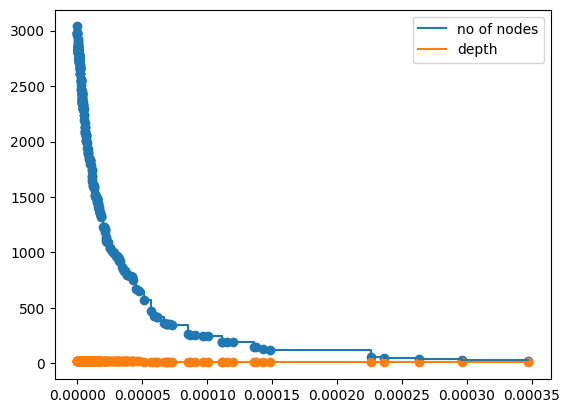

In [49]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

plt.scatter(ccp_alphas, node_counts)
plt.scatter(ccp_alphas, depth)

plt.plot(ccp_alphas, node_counts, label = 'no of nodes',drawstyle = "steps-post")
plt.plot(ccp_alphas, depth, label = 'depth',drawstyle = "steps-post")

plt.legend()
plt.show()

**Observation**

- As alpha increase number of nodes decrease but depth does not change much.

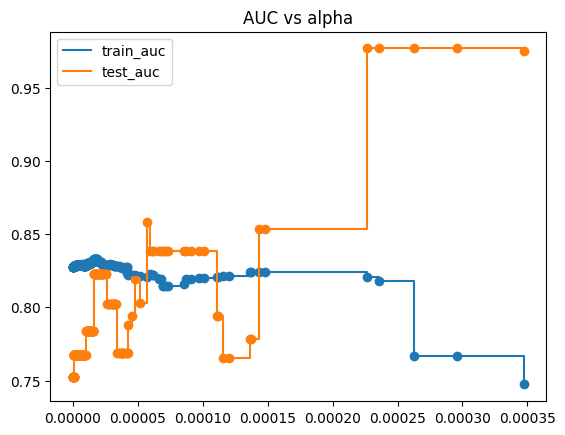

In [50]:
train_auc = []
test_auc = []

for c in clfs:
    
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)

    train_auc.append(roc_auc_score(y_train_pred, Y_train))
    test_auc.append(roc_auc_score(y_test_pred, Y_test))

plt.scatter(ccp_alphas,train_auc)
plt.scatter(ccp_alphas,test_auc)

plt.plot(ccp_alphas, train_auc, label = 'train_auc', drawstyle = "steps-post")
plt.plot(ccp_alphas, test_auc, label = 'test_auc', drawstyle = "steps-post")
plt.legend()
plt.title('AUC vs alpha')
plt.show()

**Observation**

 - Plot look crowded
 - Initial alphas where score of train and test are much close to each other compare to other points

 Let's zoom out values of alphas that works for both train and test and then visualization those points on plot.

In [51]:
#Return the index where test score is more the 0.82. We shall use those index on train and get the equivelemnt score in train dataset.
test_np = np.array(test_auc)
index = np.where(test_np > 0.82)

print(f'Index in test where auc > 0.82: {index}')
print(f'AUC score in the test: {list(map(test_auc.__getitem__, index[0]))}')

Index in test where auc > 0.82: (array([190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
       258, 265, 266, 267, 268, 269, 270, 271], dtype=int64),)
AUC score in the test: [0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8229527104959632, 0.8581081081081081, 0.8386243386243386, 0.8386243386243386, 0.8386243386243386, 0.8386243386243386, 0.8386243386243386, 0.8386243386243386, 0.8386243386243386, 0.83

In [52]:
print(f'AUC score in the train: {list(map(train_auc.__getitem__, index[0]))}')

AUC score in the train: [0.8326795155108776, 0.8328192239976098, 0.8329594270180918, 0.8329642054714568, 0.8332588655642283, 0.8332588655642283, 0.8332588655642283, 0.8332588655642283, 0.8331221272040672, 0.833271526338532, 0.8331342795524793, 0.8311799998203684, 0.8310414120747651, 0.8310414120747651, 0.8307636543862879, 0.8307636543862879, 0.8307655108136692, 0.8310479343420991, 0.8297827302657488, 0.8293580259806992, 0.8293543963922728, 0.8293535125725812, 0.8290685698109364, 0.8287780432080551, 0.8287780432080551, 0.8209904732675882, 0.8224929853196089, 0.8221138145442776, 0.8221138145442776, 0.8196890830421278, 0.8192783337831375, 0.8143395778328257, 0.8143395778328257, 0.8143395778328257, 0.8143395778328257, 0.8156495330898573, 0.8196884972222387, 0.8196884972222387, 0.8199723511359454, 0.8199723511359454, 0.8244627501880558, 0.8239574506011893, 0.8204001889624765, 0.8178758406224605, 0.7665098362373849, 0.7665098362373849, 0.7473056480859719]


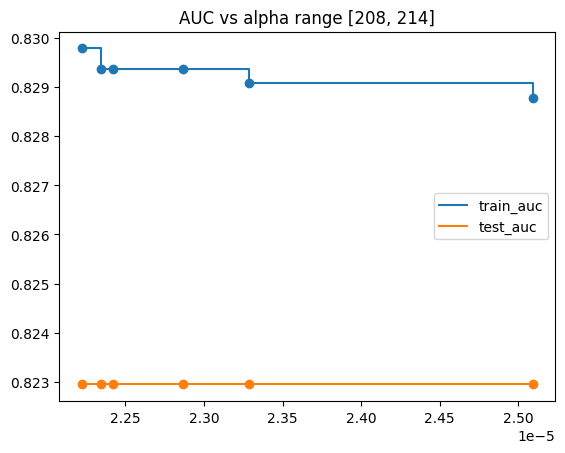

In [54]:
sub_set_train_auc = []
sub_set_test_auc = []

alpha_start = 208
alpha_end = 214

for c in clfs[alpha_start : alpha_end]:
    
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)

    sub_set_train_auc.append(roc_auc_score(y_train_pred, Y_train))
    sub_set_test_auc.append(roc_auc_score(y_test_pred, Y_test))

plt.scatter(ccp_alphas[alpha_start : alpha_end], sub_set_train_auc)
plt.scatter(ccp_alphas[alpha_start : alpha_end], sub_set_test_auc)

plt.plot(ccp_alphas[alpha_start : alpha_end], sub_set_train_auc, label = 'train_auc', drawstyle = "steps-post")
plt.plot(ccp_alphas[alpha_start : alpha_end], sub_set_test_auc, label = 'test_auc', drawstyle = "steps-post")
plt.legend()
plt.title(f'AUC vs alpha range [{alpha_start}, {alpha_end}]')
plt.show()

In [55]:
ccp_alphas[alpha_start : alpha_end]

array([2.22223768e-05, 2.23450389e-05, 2.24222682e-05, 2.28655447e-05,
       2.32864278e-05, 2.50936517e-05])

**Observation**

- alpha of 2.32864278e-05 gave good score in both train and test data set

Lets test this value with Cross validation. 

**Output:**


<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.745</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.90</td>
    <td>0.70</td>
</tr>
</table>
